In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
sns.set()

In [3]:
kq4_data = pd.read_excel('data/KQ4 Workbook.xlsx', sheetname='Sheet1', na_values=['NR', 'NA']).drop(['Notes'], axis=1)
kq4_data.head()

,Author,RefID,LMS Total,Pre-op,Initial Surgery,Morcellation,Power,Cancer Stage,Upstaged,Months follow-up,Outcome,Age,Menopausal Status
0,Einstein,405.0,5.0,Benign,LSC SCC,Yes,Yes,I,No,30.0,NED,NaN,NaN
1,Einstein,405.0,NaN,Benign,LMYOM,Yes,Yes,I to III,Yes,61.0,NED,NaN,NaN
2,Einstein,405.0,NaN,Benign,SCH,Yes,No,I to III,Yes,31.0,AWD,NaN,NaN
3,Einstein,405.0,NaN,Benign,SCH BSO,No,No,I,No,37.0,NED,NaN,NaN
4,Einstein,405.0,NaN,Benign,SCH BSO,No,No,I to IV,Yes,6.0,AWD,NaN,NaN


Some studies show event time truncated to the end of the followup period

In [4]:
followup_event_time = ['Lin', 'Perri', 'Park']
kq4_data['followup_event_time'] = kq4_data.Author.isin(followup_event_time)
kq4_data.followup_event_time.value_counts()

True     127
False     70
Name: followup_event_time, dtype: int64

In [5]:
kq4_data.isnull().mean().round(2)

Author                 0.00
RefID                  0.48
LMS Total              0.91
Pre-op                 0.19
Initial Surgery        0.01
Morcellation           0.01
Power                  0.22
Cancer Stage           0.17
Upstaged               0.81
Months follow-up       0.14
Outcome                0.01
Age                    0.27
Menopausal Status      0.46
followup_event_time    0.00
dtype: float64

In [6]:
kq4_data = kq4_data.dropna(axis='rows', subset=['Months follow-up'])

In [7]:
kq4_data.Outcome.value_counts()

Alive    78
Dead     51
NED      20
AWD      13
Died      8
Name: Outcome, dtype: int64

In [8]:
kq4_data['Pre-op'].value_counts()

Benign    133
Name: Pre-op, dtype: int64

In [9]:
pd.crosstab(kq4_data.Morcellation, kq4_data.Power)

Power,No,Yes
Morcellation,,
No,76,0
Yes,22,30


In [10]:
kq4_data['Initial Surgery'].value_counts()

TAH            73
LSC ASST VH    18
ABD MYOM       12
LSC SCH        11
LSC TVH         8
Varied          7
LSC MYOM        6
H'SCOPE MYO     6
LSC HYST        6
SCH             5
LMYOM           3
TAH UT INJ      2
VAG HYST        2
MIS HYST        2
SCH BSO         2
TVH             2
LAVH            2
TAH BSO         1
LSC SCC         1
Robotic TLH     1
Name: Initial Surgery, dtype: int64

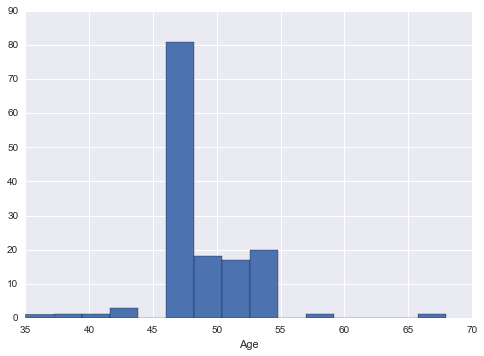

In [11]:
axes = kq4_data.Age.hist(bins=15)
axes.set_xlabel('Age')

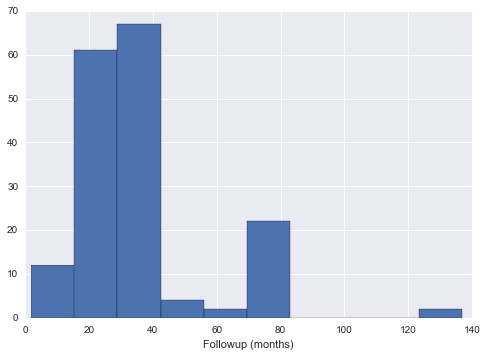

In [12]:
axes = kq4_data['Months follow-up'].hist()
axes.set_xlabel('Followup (months)')

Create death outcome column

In [13]:
kq4_data['died'] = kq4_data.Outcome.isin(['Dead', 'Died'])
kq4_data.loc[kq4_data.Outcome.isnull(), 'died'] = np.nan
kq4_data.died.value_counts()

0.0    111
1.0     59
Name: died, dtype: int64

In [14]:
kq4_data = kq4_data.dropna(subset=['Morcellation', 'Power']).reset_index(drop=True)

In [15]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [16]:
kmf.fit(kq4_data['Months follow-up'], event_observed=kq4_data.died)

<lifelines.KaplanMeierFitter: fitted with 128 observations, 87 censored>

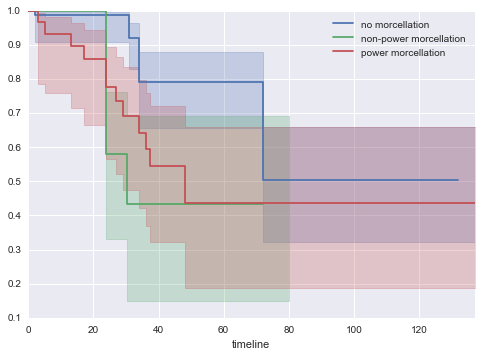

In [17]:
time = kq4_data['Months follow-up']
event = event_observed=kq4_data.died
ix0 = kq4_data.Morcellation=='No'
ix1 = (kq4_data.Morcellation=='Yes') & (kq4_data.Power=='No')
ix2 = (kq4_data.Morcellation=='Yes') & (kq4_data.Power=='Yes')



kmf.fit(time[ix0], event[ix0], label='no morcellation')
ax = kmf.plot()

kmf.fit(time[ix1], event[ix1], label='non-power morcellation')
kmf.plot(ax=ax)

kmf.fit(time[ix2], event[ix2], label='power morcellation')
kmf.plot(ax=ax)

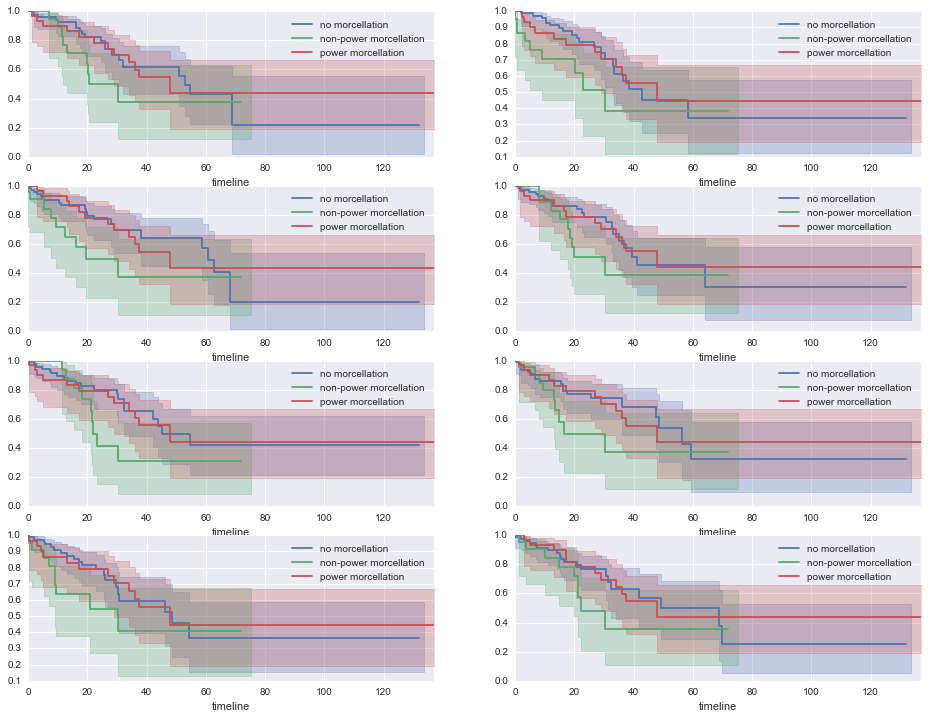

In [18]:
fig, axes = plt.subplots(4,2,figsize=(16,12))

for ax in axes.flatten():
    
    time_sim = kq4_data['Months follow-up'].copy()
    event = event_observed=kq4_data.died
    time_sim.loc[kq4_data.followup_event_time] = np.random.uniform(0, time_sim[kq4_data.followup_event_time])
    
    ix0 = kq4_data.Morcellation=='No'
    ix1 = (kq4_data.Morcellation=='Yes') & (kq4_data.Power=='No')
    ix2 = (kq4_data.Morcellation=='Yes') & (kq4_data.Power=='Yes')

    kmf = KaplanMeierFitter()
    kmf.fit(time_sim[ix0], event[ix0], label='no morcellation')
    kmf.plot(ax=ax)

    kmf.fit(time_sim[ix1], event[ix1], label='non-power morcellation')
    kmf.plot(ax=ax)

    kmf.fit(time_sim[ix2], event[ix2], label='power morcellation')
    kmf.plot(ax=ax)

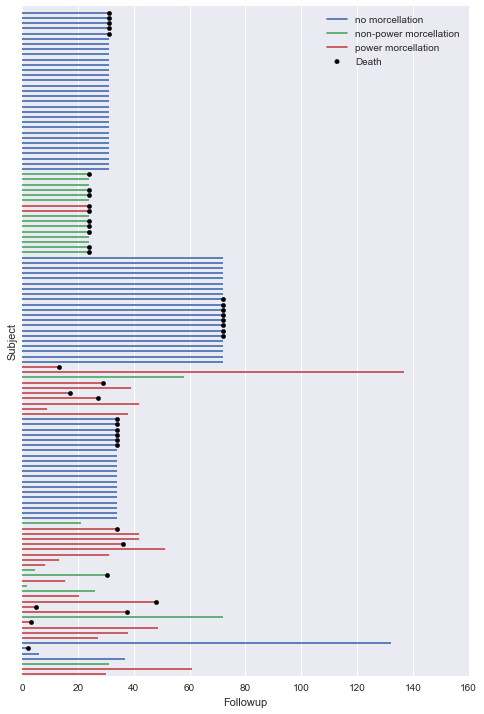

In [19]:
fig, ax = plt.subplots(figsize=(8, 12))
n_patients = kq4_data.shape[0]

blue, green, red = sns.color_palette()[:3]

ax.hlines(kq4_data.index[ix0], 0, time[ix0],
          color=blue, label='no morcellation')

ax.hlines(kq4_data.index[ix1], 0, time[ix1],
          color=green, label='non-power morcellation')

ax.hlines(kq4_data.index[ix2], 0, time[ix2],
          color=red, label='power morcellation')

ax.scatter(time[kq4_data.died == 1], kq4_data.index[kq4_data.died == 1],
           color='k', zorder=10, label='Death');

ax.set_xlim(left=0)
ax.set_ylabel('Subject')
ax.set_xlabel('Followup')
ax.set_yticks([])

ax.set_ylim(-0.25, n_patients + 0.25)

ax.legend(loc='upper right');

In [20]:
model_data = (kq4_data.assign(non_power_morcellation=(kq4_data.Morcellation=='Yes') & (kq4_data.Power=='No'))
                      .assign(power_morcellation=(kq4_data.Morcellation=='Yes') & (kq4_data.Power=='Yes')))

In [21]:
time = model_data['Months follow-up']
event = event_observed = model_data.died.astype(int)
n_intervals = int(time.max()+1)
n_patients = model_data.shape[0]

In [22]:
time_missing = model_data['Months follow-up'].copy()
time_missing[model_data.followup_event_time] = 1
time_masked = np.ma.masked_values(time_missing, value=1)

non_power, power = model_data[['non_power_morcellation', 'power_morcellation']].values.astype(int).T

In [38]:
from pymc3 import Normal, Deterministic, sample, NUTS, Model, DensityDist, Uniform, Metropolis, find_MAP, Gamma
from pymc3 import traceplot, forestplot, summary, sample_ppc
import theano.tensor as tt

In [24]:
with Model() as model:
    
    # Impute missing event times
    time_imputed = Uniform('time_imputed', np.zeros(n_patients), time.values, 
                              observed=time_masked, testval=2)

    # Linear model parameters
    β = Normal('β', mu=0.0, tau=0.0001, shape=3)

    # Survival rates
    λ = Deterministic('λ', tt.exp(β[0] + β[1] * non_power + β[2] * power))

    # Exponential survival likelihood, accounting for censoring
    def logp(event):
        return event * tt.log(λ) - λ * time_imputed

    survival = DensityDist('survival', logp, observed={'event':event})


In [25]:
n_iterations = 20000
n_burn = 10000

In [26]:
with model:
    trace = sample(n_iterations, step=Metropolis())

 [-----------------100%-----------------] 20000 of 20000 complete in 4.7 sec

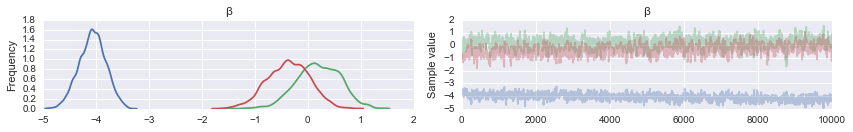

In [28]:
traceplot(trace[n_burn:], varnames=['β']);

In [29]:
summary(trace[n_burn:], varnames=['β'])


β:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -4.070           0.254            0.015            [-4.578, -3.590]
  0.200            0.421            0.021            [-0.643, 0.959]
  -0.363           0.403            0.022            [-1.117, 0.436]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -4.573         -4.239         -4.065         -3.897         -3.577
  -0.626         -0.077         0.201          0.508          0.981
  -1.168         -0.641         -0.354         -0.083         0.398



/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


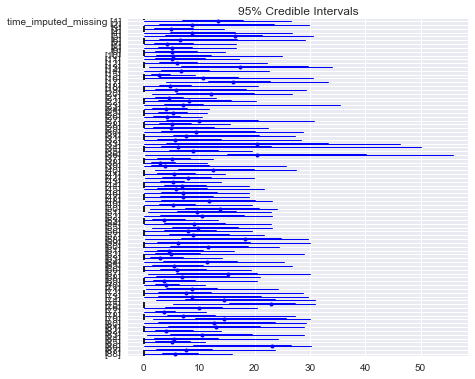

In [30]:
forestplot(trace, varnames=['time_imputed_missing'])

In [31]:
baseline_hazard = np.exp(trace['β'][n_burn:, 0])
non_power_hazard = np.exp(trace['β'][n_burn:, 0] + trace['β'][n_burn:, 1])
power_hazard = np.exp(trace['β'][n_burn:, 0] + trace['β'][n_burn:, 2])

In [32]:
hazard_df = pd.DataFrame({'baseline':baseline_hazard, 'non-power':non_power_hazard, 'power':power_hazard})

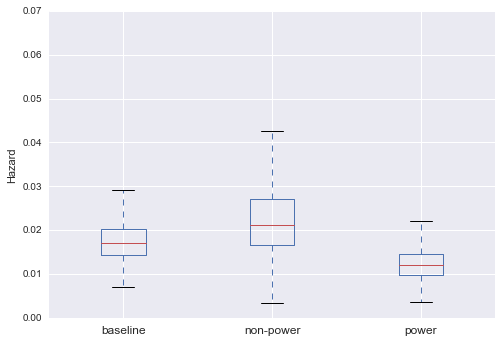

In [33]:
hazard_df.boxplot()
plt.ylabel('Hazard');

In [34]:
def cum_hazard(hazard, n=n_intervals):
    return (np.arange(n) * hazard.reshape(-1,1)).cumsum(axis=-1)

def survival(hazard):
    return np.exp(-cum_hazard(hazard))

In [35]:
def plot_with_hpd(x, hazard, f, ax, color=None, label=None, alpha=0.05):

    mean = f(hazard.mean(axis=0))
    
    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(hazard), percentiles, axis=0)
    
    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.25)
    ax.step(x, mean.squeeze(), color=color, label=label);

In [36]:
interval_bounds = np.arange(0, time.max() + 2, 1)

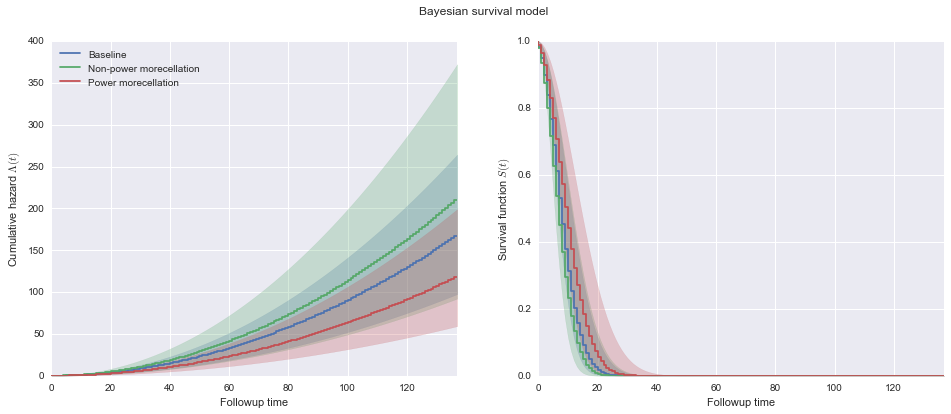

In [37]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

plot_with_hpd(interval_bounds[:-1], baseline_hazard, cum_hazard,
              hazard_ax, color=blue, label='Baseline')
plot_with_hpd(interval_bounds[:-1], non_power_hazard, cum_hazard,
              hazard_ax, color=green, label='Non-power morecellation')
plot_with_hpd(interval_bounds[:-1], power_hazard, cum_hazard,
              hazard_ax, color=red, label='Power morecellation')

hazard_ax.set_xlim(0, time.max());
hazard_ax.set_xlabel('Followup time');

hazard_ax.set_ylabel(r'Cumulative hazard $\Lambda(t)$');

hazard_ax.legend(loc=2);

plot_with_hpd(interval_bounds[:-1], baseline_hazard, survival,
              surv_ax, color=blue)
plot_with_hpd(interval_bounds[:-1], non_power_hazard, survival,
              surv_ax, color=green)
plot_with_hpd(interval_bounds[:-1], power_hazard, survival,
              surv_ax, color=red)

surv_ax.set_xlim(0, time.max());
surv_ax.set_xlabel('Followup time');

surv_ax.set_ylabel('Survival function $S(t)$');

fig.suptitle('Bayesian survival model');

## Cox model

In [ ]:
with Model() as cox_model:
    
    # Impute missing event times
    time_imputed = Uniform('time_imputed', np.zeros(n_patients), time.values, 
                              observed=time_masked, testval=2)
    
    interval_bounds = np.arange(0, time_masked.max() + 2, 1)
    n_intervals = len(interval_bounds) - 1
    
    # risk set equals one if obs_t >= t
    Y = tt.ge(time_imputed.dimshuffle(0, 'x'), interval_bounds[:-1].reshape(1, -1))
    
    import pdb;pdb.set_trace()
    last_period = tt.cast(tt.floor(time_imputed), 'int32')
    
    dN = tt.zeros((n_patients, n_intervals))
    dN = Y * tt.set_subtensor(dN[tt.arange(n_patients), last_period], event)
    
#     dN = tt.ge(time_imputed.dimshuffle(0, 'x')[1:], )
#     # counting process. jump = 1 if obs_t \in [t[j], t[j+1])
#     dN = np.array([[Y[i,j]*int(t[j+1] >= obs_t[i])*fail[i] for j in range(T)] for i in
#                     range(nsubj)])

    c = Gamma('c', .0001, .00001)
    r = Gamma('r', .001, .0001)
    
    dL0_star = r*tt.extra_ops.diff(time_imputed)
    
    # prior mean hazard
    μ = Deterministic('μ', dL0_star * c) 
    
    dL0 = Gamma('dL0', μ, c, shape=μ.tag.test_value.shape[0])

    β = Normal('β', np.zeros(2), sd=np.ones(2)*1000, shape=2)
    
    X = model_data[['non_power_morcellation', 'power_morcellation']].values

    linear_model = tt.exp(tt.dot(X, β))

    idt = Y[:, :-1] * tt.outer(linear_model, dL0)

    dn_like = Poisson('dn_like', idt, observed=dN)

In [52]:
np.diff([2,3,4])

array([1, 1])